# Image Alignment
**Satya Mallick, LearnOpenCV.com**

## Align an image to a template.
![alt text](image-alignment-using-opencv.jpg "Image Alignment")

## Theory

1. A **Homography** transforms a square to arbitrary quad. 

![alt text](motion-models.jpg "Motion Models")






## Theory
2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography


!["Homography Example"](homography-example.jpg)|

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Read Tempalate and Scanned Image

In [2]:
# Read reference image
refFilename = "form.jpg"
print("Reading reference image : ", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align : ", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
  

Reading reference image :  form.jpg
Reading image to align :  scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

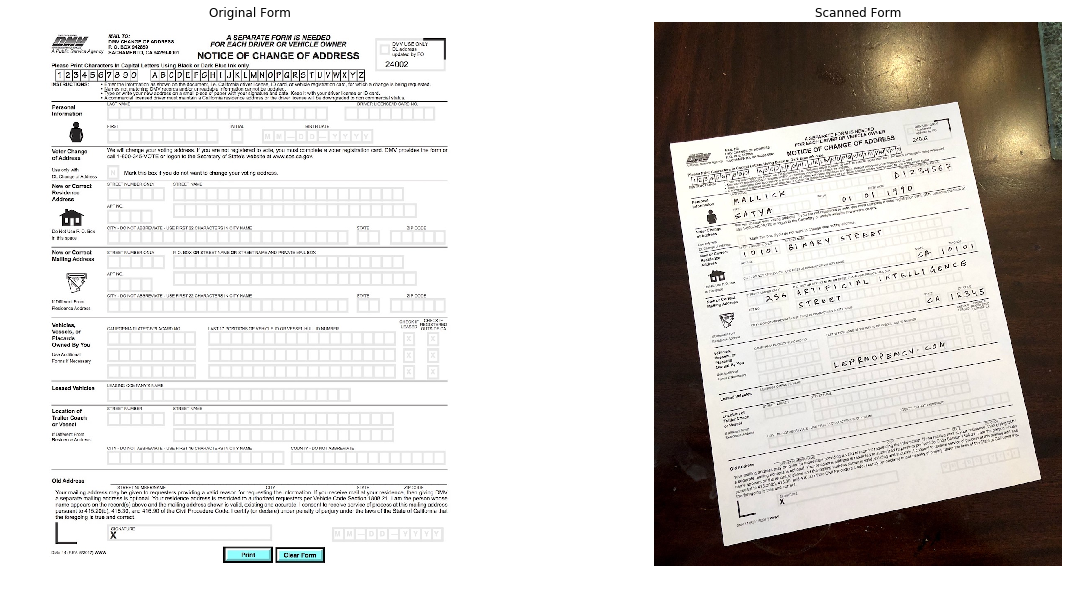

In [3]:
# Display Images

plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

## Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

In [4]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

##

idx = 1
print ("keypoint angle: ", keypoints1[idx].angle)
print ("keypoint size:  ", keypoints1[idx].size)
print ("keypoint x:     ", keypoints1[idx].pt[0])
print ("keypoint y:     ", keypoints1[idx].pt[1])
print ("")
print ("descriptor: ", descriptors1[idx])
print ("")

# Display 
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


keypoint angle:  72.91248321533203
keypoint size:   31.0
keypoint x:      68.0
keypoint y:      939.0

descriptor:  [ 77 196 252 211 226 122 125 190  58  51  38 146 221  55 206 127  39 215
 177 158  49 216  61 226 111 239 254  68 166 209 193 104]



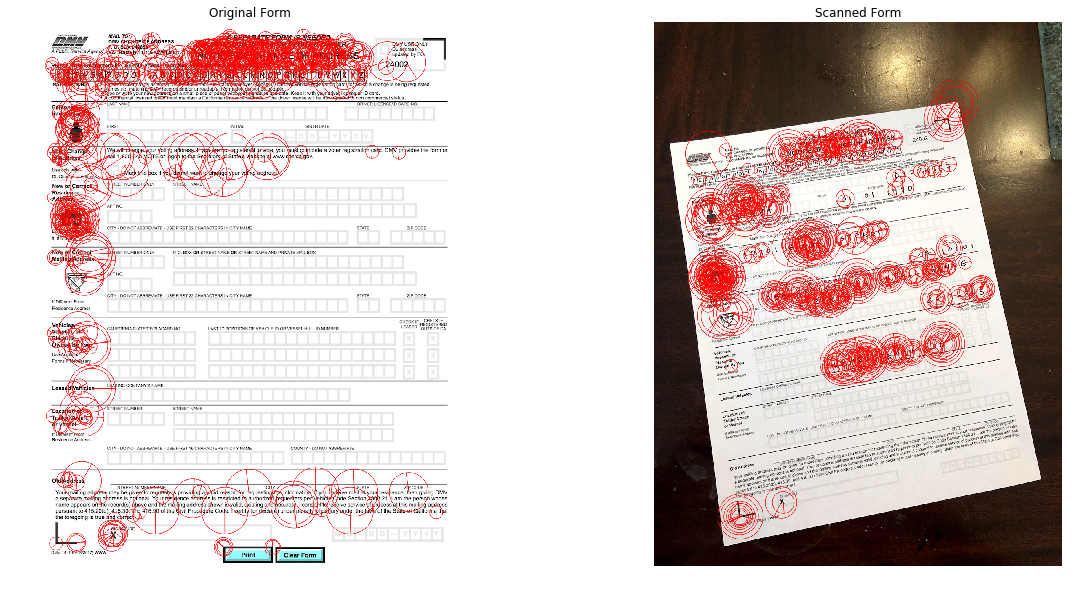

In [5]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

## Step 3 : Match keypoints in the two image

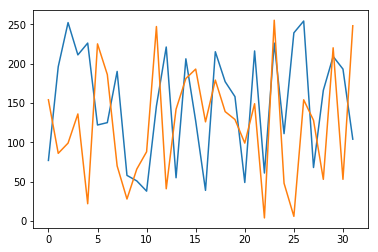

In [6]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)
  
# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.10)
matches = matches[:numGoodMatches]

##
d1 = descriptors1[1]
d2 = descriptors2[1]
plt.plot(d1)
plt.plot(d2)


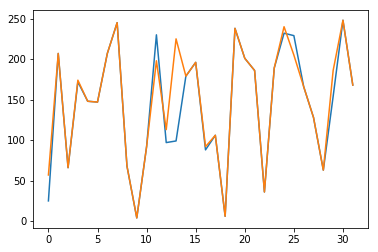

In [7]:
idx = 0
d1 = descriptors1[matches[idx].queryIdx]
d2 = descriptors2[matches[idx].trainIdx]
plt.plot(d1)
plt.plot(d2)

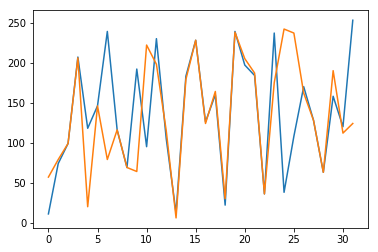

In [8]:
idx = len(matches)-1
d1 = descriptors1[matches[idx].queryIdx]
d2 = descriptors2[matches[idx].trainIdx]
plt.plot(d1)
plt.plot(d2)

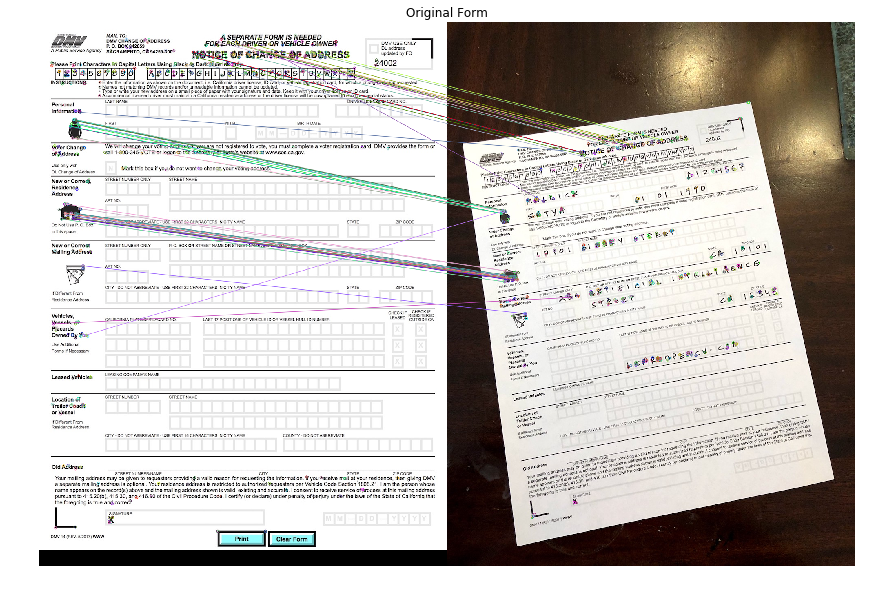

In [9]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");


## Step 4:  Find Homography



In [10]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
  points1[i, :] = keypoints1[match.queryIdx].pt
  points2[i, :] = keypoints2[match.trainIdx].pt
  
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

idx = 10
print("Homography")
print(h)
print("")
print("Point-1 (template)")
print(points1[idx, :])
print("")
print("Point-2 (scan)")
print(points2[idx, :])
print("")

print("Express point-2 (scan) in homogeneous coordinates")
p2_homo = np.append(points2[idx, :],1)
print(p2_homo)
print("")

p1_homo = np.matmul(h,p2_homo.T)
print("p1_homo = H * p2_homo")
print(p1_homo)
print("")
print("Normalized p1_homo (template)")
print (p1_homo/p1_homo[2])

Homography
[[ 1.39529971e+00 -2.05238332e-01 -4.55866851e+00]
 [ 2.21253447e-01  1.53862311e+00 -4.86451773e+02]
 [-7.76781282e-05  1.52498096e-04  1.00000000e+00]]

Point-1 (template)
[ 97.920006 482.40002 ]

Point-2 (scan)
[172. 631.]

Express point-2 (scan) in homogeneous coordinates
[172. 631.   1.]

p1_homo = H * p2_homo
[105.92749448 522.47500348   1.08286566]

Normalized p1_homo (template)
[ 97.82145498 482.4929097    1.        ]


## Step 5: Warp image

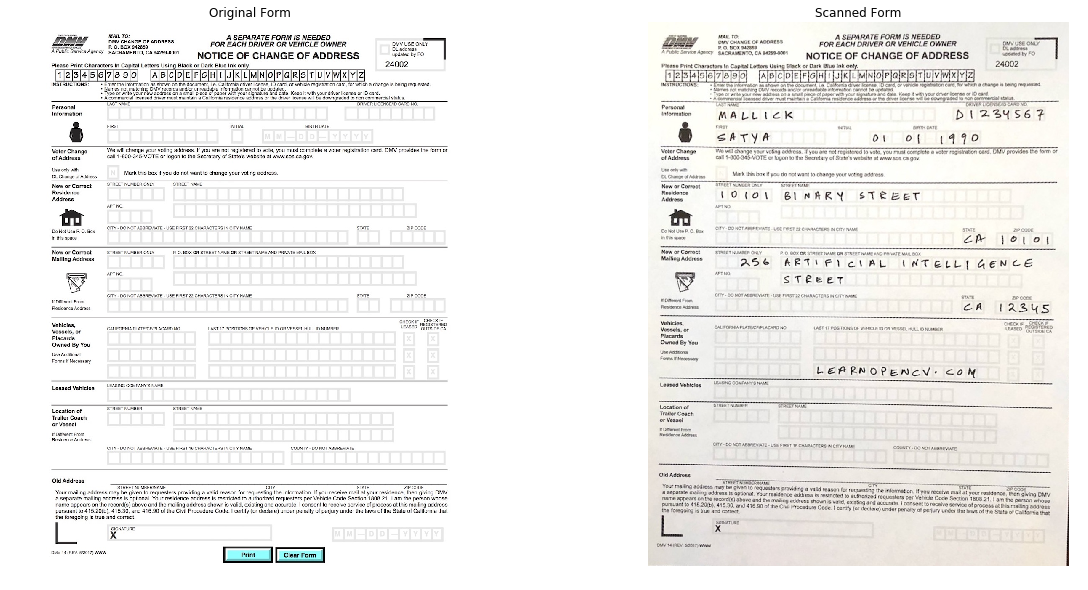

In [11]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))
# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(im1); plt.axis('off'); plt.title("Original Form");
plt.subplot(122); plt.imshow(im2_reg); plt.axis('off'); plt.title("Scanned Form");